# Анализ итогов работы магазина "Стримчик" за 2016 год

Мы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение данных из файлов

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats as st
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('datasets/games.csv')

In [3]:
df.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
2191,Rocksmith 2014,X360,2013.0,Misc,0.69,0.16,0.00,0.09,NaN,NaN,NaN
3145,Tom Clancy's Rainbow Six,N64,1999.0,Shooter,0.48,0.15,0.00,0.01,NaN,NaN,NaN
10300,Sonic Generations,PC,2011.0,Platform,0.02,0.07,0.00,0.02,77.0,8.3,E
11616,Ape Escape: Pumped & Primed,PS2,2004.0,Misc,0.04,0.03,0.00,0.01,NaN,NaN,NaN
14862,Kabu Trader Shun,DS,2007.0,Action,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [4]:
df.columns=df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
df.user_score.value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
9.6       2
0.5       2
0.6       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [7]:
df.rating.value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [10]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [11]:
df[df['na_sales']==0]['na_sales'].count()

4508

In [12]:
df[df['eu_sales']==0]['eu_sales'].count()

5870

In [13]:
df[df['jp_sales']==0]['jp_sales'].count()

10514

In [14]:
df[df['other_sales']==0]['other_sales'].count()

6601

### Выводы

- сразу привели названия столбцов к стандартному виду;
- тип некоторых столбцов не соответствует числовому типу по причине наличие нечисловых элементов в столбцах;
- есть большое количество нулевых значений появление которых связано с тем, что в этих регионах игры не продавались;
- также есть столбцы с пропусками: год выпуска, оценка критиков, оценка пользователей и рейтинг ESRB;




## Предобработка данных

In [15]:
# данные по дате выпуска являются важными, но непонятно на что их можно заменить, 
# с учетом того что пропусков не так много относительно общего числа, считаю что можно их удалить
df = df[~(df['year_of_release'].isna())]

In [16]:
df['user_score'] = df['user_score'].replace('tbd', -1)
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')
df['rating']=df['rating'].fillna('No rating')

In [17]:
df.year_of_release = pd.to_numeric(df.year_of_release, errors='coerce').astype('int')

In [18]:
df['sum'] = df[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

### Выводы

- удалили данные с отсутствующим годом выпуска игр, так как это очень важная информацию и без нее нельзя определить актуальный период для прогноза;
- значение tbd из столбца с пользовательским рейтингом заменили на -1 чтобы можно было работать с этими данными, но не использовать для оценки рейтинга. Замену на среднюю величину существенно смещала бы оценку;
- преобразовали столбцы с пользовательским рейтингом и годом выхода игры к числовому виду;
- добавили столбец с суммарными продажами;
- с пропусками в рейтингах непонятно что делать без дополнительной информации, поэтому принял решения не на что их не менять чтобы не смещать статистики.


## Исследовательский анализ данных


### Распределение выпуска игр по годам

Text(0.5, 0, 'Годы')

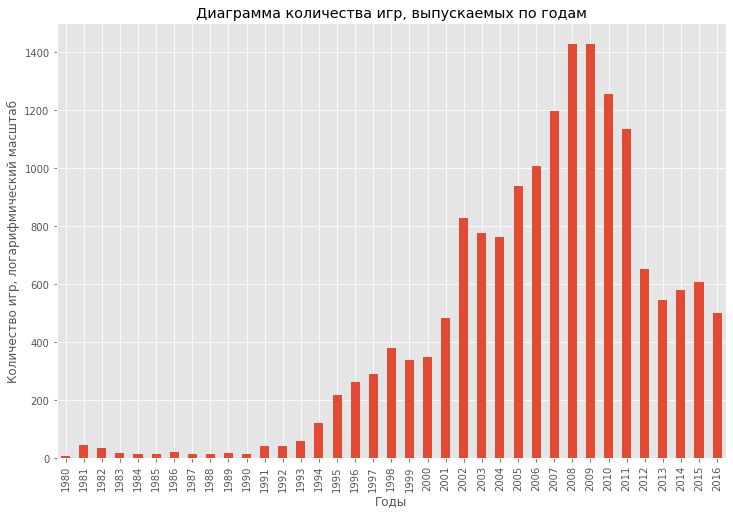

In [19]:
ax = df.groupby('year_of_release').\
    agg( {'name':'count'}).\
    plot(kind='bar', figsize=(12,8),grid=True, log= False, title='Диаграмма количества игр, выпускаемых по годам', legend = False )
ax.set_ylabel("Количество игр, логарифмический масштаб")
ax.set_xlabel("Годы")

Из анализа графика можно сделать следующие выводы:
- по сравнению с 1980 годом выпуск игр увеличился в больше чем на два порядка;
- максимум вупуск игр достиг в 2008-2009 годах и потом начал уменьшаться.

### Анализ игровых платформ по годам

**График жизненного цикла для различных игровых платформ**

In [20]:
df_agg = df.pivot_table(index='year_of_release', columns=['platform'],  aggfunc={"name":'count'}).\
    count()
df_agg.sort_values()

      platform
name  GG           1
      PCFX         1
      TG16         1
      3DO          2
      SCD          2
      WS           3
      NG           4
      PS4          4
      XOne         4
      WiiU         5
      GEN          5
      3DS          6
      SAT          6
      PSV          6
      GC           7
      N64          7
      DC           7
      GBA          8
      XB           9
      SNES        10
      2600        10
      PS          10
      PS3         11
      Wii         11
      DS          11
      PS2         12
      NES         12
      X360        12
      PSP         12
      GB          13
      PC          26
dtype: int64

Text(0.5, 0, 'Игровые платформы')

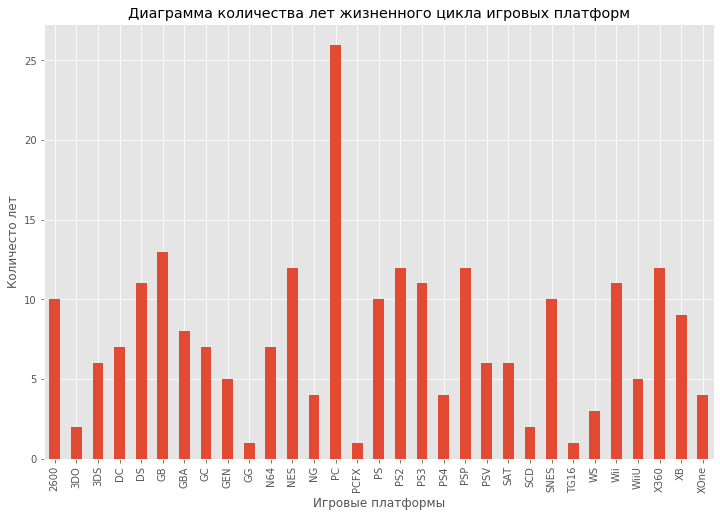

In [21]:
ax = df_agg.reset_index(drop=True, level=0).\
plot(kind='bar', figsize=(12,8),grid=True, title='Диаграмма количества лет жизненного цикла игровых платформ', legend = False )
ax.set_ylabel("Количесто лет")
ax.set_xlabel("Игровые платформы")


Text(0.5, 0, 'Количество лет')

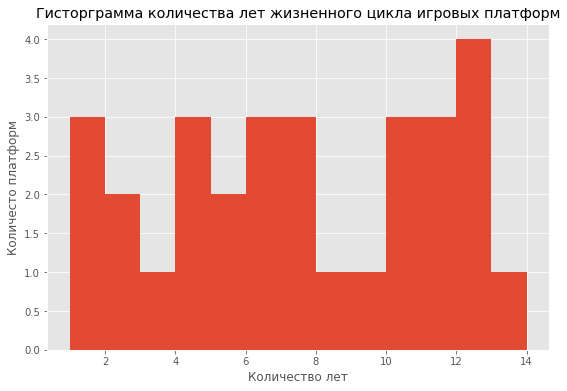

In [22]:
ax = df_agg.reset_index(drop=True, level=0).\
plot(kind='hist', bins=13, figsize=(9,6), range=(1,14), grid=True, title='Гисторграмма количества лет жизненного цикла игровых платформ', legend = False )
ax.set_ylabel("Количесто платформ")
ax.set_xlabel("Количество лет")

Из анализа графика можно сделать следующие выводы:
- по сравнению с 1980 годом выпуск игр увеличился в больше чем на два порядка;
- максимум выпуск игр достиг в 2008-2009 годах и потом начал уменьшаться.
Из представленных графиков можно сделать следующие выводы: 
- время жизни платформы весьма неоднородно и может быть от 1 года до 26 лет;
- одна платформа PC - 26 лет. Это можно признать аномалией. Если большинство игр разрабатывается под свою аппаратную платформу, то PC разрабатывается для персональных компьютеров, которые прошли путь от 486 до i9 11-го поколения. Поэтому можно условно считать, что эта одна платформа; 
- можно условно выделить следующие группы: 
    - "неудачные" - до 3 лет жизни. Проекты были признаны неудачные и вскоре были закрыты;
    - "средний вариант" - от 4 до 8 лет жизни. Проекты развивались некоторое время, но были закрыты;
    - "ветераны" - от 10 лет. Платформы 


**Расчет среднего времени жизни игровой платформы от начала выпуска первых игр до выпуска последних:**

In [23]:
df.pivot_table(index='year_of_release', columns=['platform'], aggfunc={"name":'count'}).count().mean()

7.67741935483871

In [24]:
df[df['platform']!='PC'].\
pivot_table(index='year_of_release', columns=['platform'], aggfunc={"name":'count'}).count().mean()

7.066666666666666

- так как основная задача стоит в разработке рекомендаций, c учетом того, что жизненный цикл для игровых платформ составляет 7.68 лет, поэтому выберем в качестве периода для прогноза соизмеримую увеличу в 3 года. Поэтому будем использовать данные с 2014 по 2016 года. 
- среднее значение без платформы PC меньше на 0.6 года, в тоже время мы используем ограниченный промежуток по времени, поэтому некоторые платформы не закончили свой жизненный цикл, поэтому средняя в этом случае смещается вниз. Поэтому правильнее оценивать, наверное, все же жизненный цикл величиной просто среднего - 7.68 лет.


### Оценка платформ за актуальный период

In [25]:
df_dop = df[df['year_of_release']>=2016].\
    pivot_table(index='year_of_release', columns=['platform'], aggfunc={"name":'count'}).\
    mean().\
    sort_values(ascending=False).\
    reset_index().\
    drop('level_0', axis=1).head(10)
df_dop.columns = ['platform', 'mean']

In [26]:
df_dop

,platform,mean
0,PS4,164.0
1,XOne,87.0
2,PSV,85.0
3,PC,54.0
4,3DS,46.0
5,PS3,38.0
6,WiiU,14.0
7,X360,13.0
8,Wii,1.0


Text(0.5, 0, 'Игровые платформы')

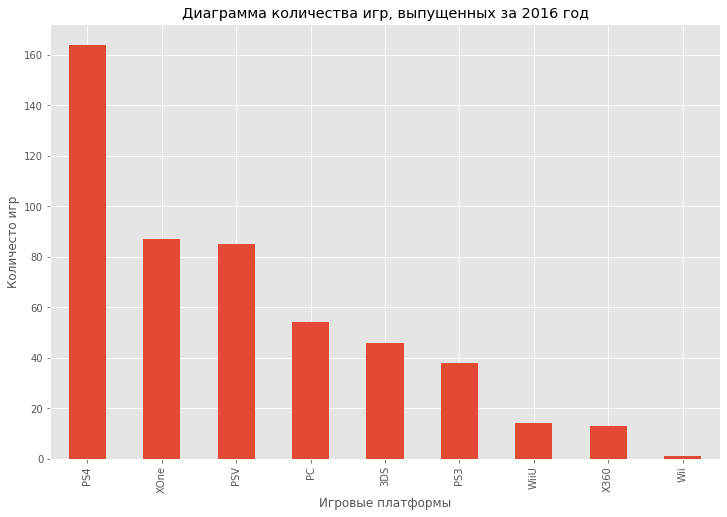

In [27]:
df_dop.index=df_dop.platform
ax=df_dop.\
plot(kind='bar', figsize=(12,8),grid=True, title='Диаграмма количества игр, выпущенных за 2016 год', legend = False )
ax.set_ylabel("Количесто игр")
ax.set_xlabel("Игровые платформы")



Выпуск игр за 2016 год позволяют косвенно оценить перспективность платформ. Так как если игры не выпускаются, то производители игр не видят перспектив для данных платформ. Видно, что осталось всего 8 игровых платформ. Таким образом лидером можно смело назвать PS4, замет идут XOne и PSV, остальные игровые платформы заметно отстают.


**Продажи игр за актуальный период**

In [28]:
df_money = df[df['year_of_release']>=2014].\
    pivot_table(index='platform', aggfunc={'sum':'sum'})
df_money_2016=df[(df['year_of_release']>=2016)].\
    pivot_table(index='platform', aggfunc={'sum':'sum'}) 
#переименовали столбцы
df_money.columns=['sum']
df_money_2016.columns=['sum_2016']

In [29]:
#добавили столбец с данными за 3 года к данным за 2016 год
df_money_2016['sum']=df_money['sum']
#рассчитаем отношение продаж за 2016 год к средним продажам за 3 года в процентах.
df_money_2016['dynamics_percent']=100*(df_money_2016['sum_2016']-0.33*df_money_2016['sum'])/(0.33*df_money_2016['sum'])

In [30]:
df_money_2016.sort_values(by='dynamics_percent', ascending=False)

,sum_2016,sum,dynamics_percent
platform,,,
PS4,69.25,288.15,-27.173873
PC,5.25,27.05,-41.186355
PSV,4.25,22.40,-42.505411
XOne,26.15,140.36,-43.543442
3DS,15.14,86.68,-47.071080
WiiU,4.60,42.98,-67.567720
PS3,3.60,68.18,-83.999573
Wii,0.18,5.07,-89.241528
X360,1.52,48.22,-90.447821


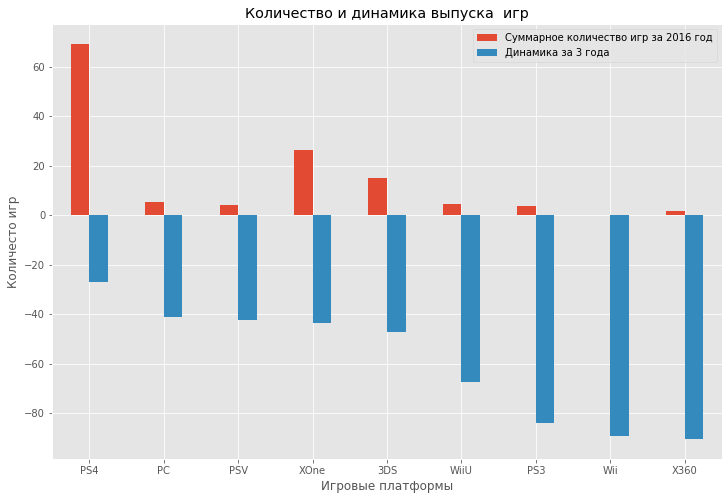

In [31]:
ax = df_money_2016[['sum_2016','dynamics_percent' ]].sort_values(by='dynamics_percent', ascending=False).\
plot(kind='bar', figsize=(12,8),grid=True, title='Количество и динамика выпуска  игр', legend = True )
ax.set_ylabel("Количесто игр")
ax.set_xlabel("Игровые платформы")
ax.legend(['Суммарное количество игр за 2016 год', 'Динамика за 3 года'])
plt.xticks(rotation=0)
plt.show()

Из анализа графика можно сделать выводы что лидируют по продажам PS4. Заметно отстают XOne и 3DS. Остальные платформы не заминают значительного положения по продажам. В целом можно отметить весьма негативные тенденции по продажам игр для игровых платформ. Лучше всего выглядит PS4, но и в это случае на лицо явно выраженные негативные тенденции. Видимо, это связано с миграцией пользователей на онлайн-игры монетизация которых отлична от монетизации анализируемых игр.

In [32]:
#функция для построения "ящика с усами" с сортировкой по убыванияю медианного значения продаж
def box_sort(df, column, by):
    df2=pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    med=df2.median().sort_values(ascending=False)
    df2[med.index].boxplot()

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


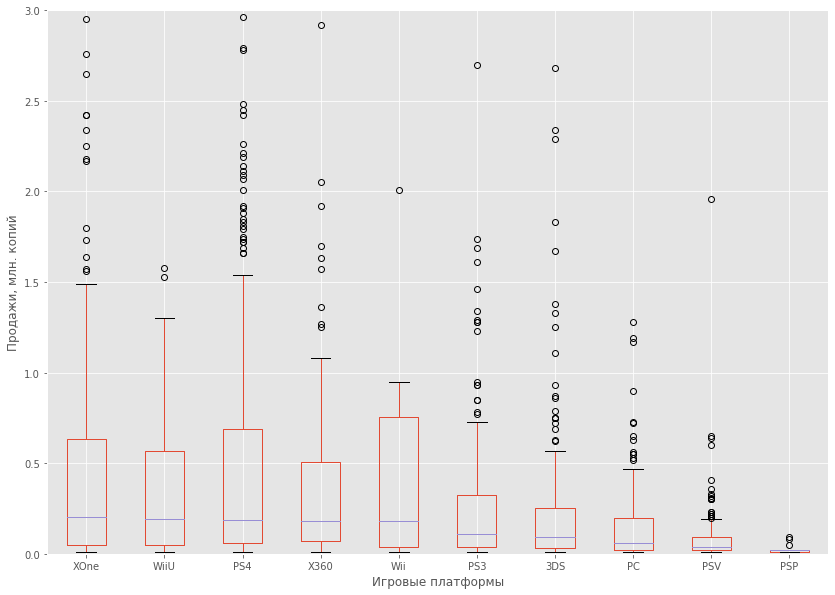

In [33]:
fig, ax = plt.subplots(figsize=(14,10))
box_sort(df[(df['year_of_release']>0)&(df['year_of_release']>=2014)],'sum', 'platform')
ax.set_ylim(0,3)
ax.set_ylabel("Продажи, млн. копий")
ax.set_xlabel("Игровые платформы")
plt.show()

Представленный график иллюстрирует распределение глобальных продаж игр в разбивке по платформам за актуальный период, 2014-2016 года. Не смотря на лидерство платформы PS4 по суммарных продажах игр, в пересчете на одну игру медианна прибыль незначительно больше у таких игровых платформ как  XOne и  WiiU. В целом можно сказать, что медианные значения для первых 5 игровых платформ мало отличаются.  Также имеется значительно число выбросов для всех платформ. Размер третьего и верхнего квартиля на графиках позволяет сказать, что имеется значительно число игр, которые гораздо успешнее по продажам чем "типичная" игра платформы.

### Анализ влияния рейтинга пользователей и критиков на продажи

In [34]:
# в рейтинге избавляется от значений -1
df[(df['platform']=='PS4')&(df['user_score']>0)&(df['year_of_release']>=2014)][['platform','critic_score', 'user_score', 'sum']].corr()

,critic_score,user_score,sum
critic_score,1.000000,0.546434,0.401903
user_score,0.546434,1.000000,-0.040132
sum,0.401903,-0.040132,1.000000


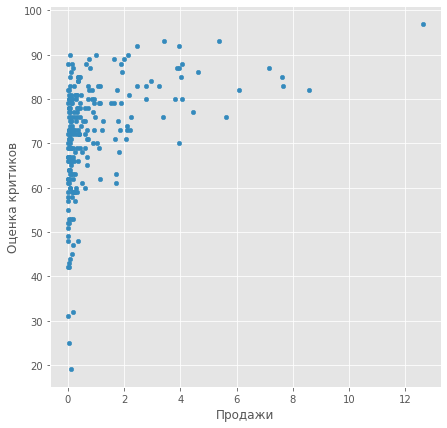

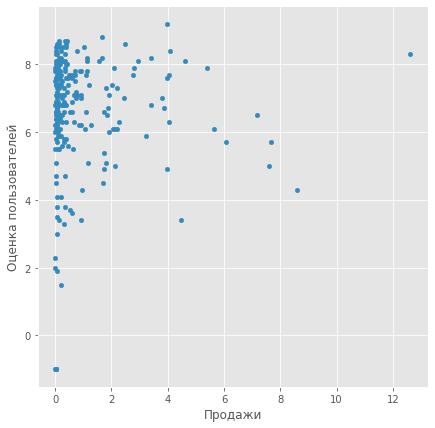

In [35]:
ax=df[(df['platform'].isin(['PS4']))&(df['year_of_release']>=2014)][['platform','critic_score', 'user_score', 'sum'  ]].\
    plot.scatter(x='sum', y='critic_score', figsize=(7,7))
ax.set_ylabel("Оценка критиков")
ax.set_xlabel("Продажи")
plt.show()
ax=df[(df['platform'].isin(['PS4']))&(df['year_of_release']>=2014)][['platform','critic_score', 'user_score', 'sum'  ]].\
    plot.scatter(x='sum', y='user_score', figsize=(7,7))
ax.set_ylabel("Оценка пользователей")
ax.set_xlabel("Продажи")
plt.show()

Из анализа графиков и коэффициентов корреляции можно сделать выводы:
- что существуюет прямая зависимость между оценкой критиков и продажами. Но связь эта умеренная. 
- связь между продажами и оценкой пользователей на основе расчета коэффициента Пирсона не выявлена. 
- Результат для оценки пользователей является неожиданным, возможно, что имеется другие переменные, которые не были учтены в данном анализе. 

In [36]:
#список с наиболее перспективными платформами
lst=['PS4','PS3','3DS', 'WiiU', 'XOne',"PC"]
d={}
# создаем ДатаФрейм для хранения коэффициентов корреляции
for i in lst:
    d[i]=list(df[(df['platform'].isin([i]))&(df['user_score']>0)&(df['year_of_release']>=2014)][['platform','critic_score', 'user_score', 'sum']].corr().iloc[2])
df_corr = pd.DataFrame(data=d)

In [37]:
# удаляем строку со значениями 1
df_corr=df_corr.drop(2, axis=0).copy()
# переименовали индексы
df_corr.index=['critic_score', 'user_score']
df_corr

,PS4,PS3,3DS,WiiU,XOne,PC
critic_score,0.401903,0.446575,0.284686,0.375640,0.422112,0.172061
user_score,-0.040132,-0.166761,0.215193,0.407926,-0.070384,-0.071597


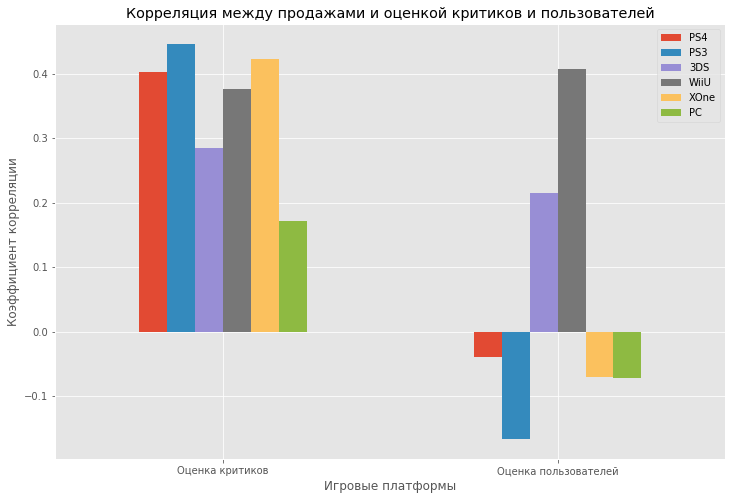

In [38]:
ax=df_corr.\
plot(kind='bar', figsize=(12,8),grid=True, title='Корреляция между продажами и оценкой критиков и пользователей', legend = True )
ax.set_ylabel("Коэффициент корреляции")
ax.set_xlabel("Игровые платформы")
stick=('Оценка критиков','Оценка пользователей' )
plt.xticks(rotation=0)
ax.set_xticklabels(stick)
plt.show()

- Из анализа корреляции между продажами и оценками критиков и пользователей можно сделать вывод что для некоторых платформ корреляция между продажами и оценкой критиков имеет умеренное значение. Наибольшее значение среди наиболее популярных платформ WiiU=0.4.
- В тоже время оценка критиков имеет примерно одинаковое влияние на продажи для анализируемых платформ. Но для PC рейтинг критиков имеет меньшее значение.


### Анализ игр по жанрам

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


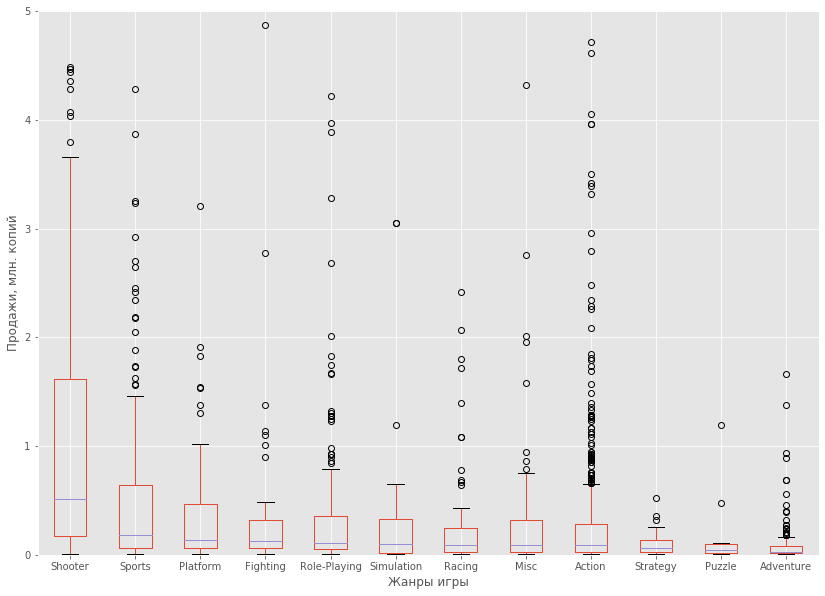

In [39]:
fig, ax = plt.subplots(figsize=(14,10))
box_sort(df[(df['year_of_release']>0)&(df['year_of_release']>=2014)],'sum', 'genre')
ax.set_ylim(0,5)
ax.set_ylabel("Продажи, млн. копий")
ax.set_xlabel("Жанры игры")
plt.show()

Анализ игр по жанрам позволяет сделать следующие выводы:
- Наиболее популярные это Шутеры, которые значительно опережают по медиане и верхней квартиле другие жанры, также в этом жанре есть игра с максимальными продажами;
- Во многих жанрах есть очень удачные игры продажи которых достигают млн. копий;
- Наименее популярные и успешные жанры — это стратегии, пазлы, приключения и симуляторы;
- Хотя Экшены, Misk и Гонки в целом не очень удачные жанры, у этих жанров есть очень удачные игры;
- Платформы хотя и заняли третье место, но в целом 


### Выводы

- по сравнению с 1980 годом выпуск игр увеличился в больше чем на два порядка;
- максимум выпуск игр достиг в 2008-2009 годах и потом начал уменьшаться.
- можно условно выделить следующие группы игр: 
    - "неудачные" - до 3 лет жизни. Проекты были признаны неудачные и вскоре были закрыты;
    - "средний вариант" - от 4 до 8 лет жизни. Проекты развивались некоторое время, но были закрыты;
    - "ветераны" - от 10 лет. Платформы завоевали свое место под солнцем и долго развивались;
- так как основная задача стоит в разработке рекомендаций, c учетом того, что жизненный цикл для игровых платформ составляет 7.68 лет, поэтому выберем в качестве периода для прогноза соизмеримую увеличу в 3 года. Поэтому будем использовать данные с 2014 по 2016 года;
- лидируют по продажам PS4. Заметно отстают XOne и 3DS. Остальные платформы не заминают значительного положения по продажам;
-  в целом можно отметить весьма негативные тенденции по продажам игр для игровых платформ. Лучше всего выглядит PS4, но и в это случае на лицо явно выраженные негативные тенденции. Видимо, это связано с миграцией пользователей на онлайн-игры монетизация которых отлична от монетизации анализируемых игр;

- несмотря на лидерство платформы PS4 по суммарных продажах игр, в пересчете на одну игру медианна прибыль незначительно больше у таких игровых платформ как  XOne и  WiiU. В целом можно сказать, что медианные значения для первых 5 игровых платформ мало отличаются.  Также имеется значительно число выбросов для всех платформ. Размер третьего и верхнего квартиля на графиках позволяет сказать, что имеется значительно число игр, которые гораздо успешнее по продажам чем "типичная" игра платформы;
- существует прямая зависимость между оценкой критиков и продажами. Но связь эта умеренная; 
- связь между продажами и оценкой пользователей на основе расчета коэффициента Пирсона не выявлена;
- результат для оценки пользователей является неожиданным, возможно, что имеется другие переменные, которые не были учтены в данном анализе;
- для некоторых платформ корреляция между продажами и оценкой критиков имеет умеренное значение. Наибольшее значение среди наиболее популярных платформ WiiU=0.4;
- В тоже время оценка критиков имеет примерно одинаковое влияние на продажи для анализируемых платформ.


## Анализ игр по регионам

In [40]:
df_region=df[(df['year_of_release']>0)&(df['year_of_release']>=2014)].\
    groupby('platform').\
    agg({'na_sales': 'sum','eu_sales': 'sum','jp_sales': 'sum','other_sales': 'sum'})

In [41]:
df_region['na_sales'].sort_values(ascending=False)

platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
WiiU    19.36
PC       7.23
PSV      2.52
Wii      2.08
PSP      0.00
Name: na_sales, dtype: float64

In [42]:
df_region['eu_sales'].sort_values(ascending=False)

platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
X360     15.49
WiiU     13.15
PSV       3.53
Wii       2.59
PSP       0.00
Name: eu_sales, dtype: float64

In [43]:
df_region['jp_sales'].sort_values(ascending=False)

platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
PSP      0.36
XOne     0.32
X360     0.08
Wii      0.00
PC       0.00
Name: jp_sales, dtype: float64

In [44]:
df_region

,na_sales,eu_sales,jp_sales,other_sales
platform,,,,
3DS,22.64,16.12,44.24,3.68
PC,7.23,17.97,0.00,1.85
PS3,22.05,25.54,11.22,9.37
PS4,98.61,130.04,15.02,44.48
PSP,0.00,0.00,0.36,0.00
PSV,2.52,3.53,14.54,1.81
Wii,2.08,2.59,0.00,0.40
WiiU,19.36,13.15,7.31,3.16
X360,28.30,15.49,0.08,4.35


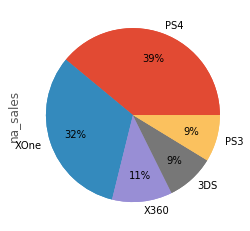

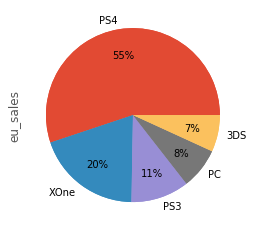

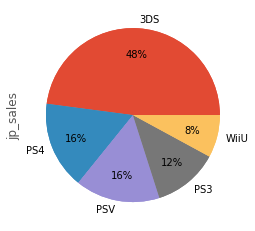

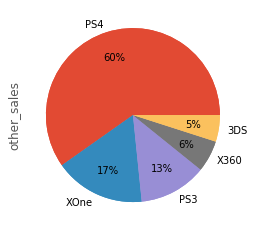

In [45]:
df_region['na_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['na_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()
df_region['eu_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['eu_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()
df_region['jp_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['jp_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()
df_region['other_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['other_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()


Из анализа графиков продажи по регионам можно сделать следующие выводы:
- Наибольшую долю рынка в Северной Америке,  ЕС и категория Другие страны занимают PS4 и XOne;
- В ЕС популярна платформа РС в отличии от других регионов;
- Предпочтения в Японии существенно отличаются от Северной Америки и ЕС: наиболее пополярны 3DS, PS4, PSV.

In [46]:
df_region=df[(df['year_of_release']>0)&(df['year_of_release']>=2014)].\
    groupby('genre').\
    agg({'na_sales': 'sum','eu_sales': 'sum','jp_sales': 'sum','other_sales': 'sum' })

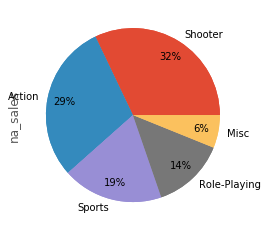

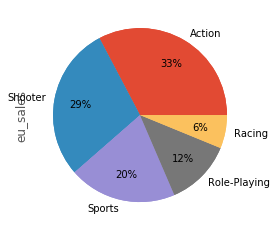

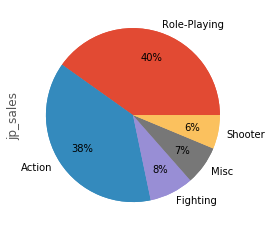

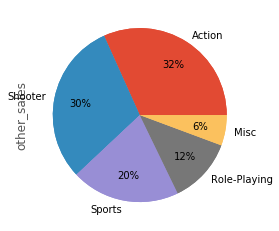

In [47]:
df_region['na_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['na_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.8, labeldistance=2)
plt.show()
df_region['eu_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['eu_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()
df_region['jp_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['jp_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()
df_region['other_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['other_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()

- В Северной Америке и ЕС наиболее популярны: Шутеры, Акшины, Спорт и Ролевые игры.
- В Северной Америке и Японии играют в Misk в отличии в ЕС;
- Популярность игр в Японии отличается от Северной Америки и ЕС: наиболее популярны ролевые игры, Экшены, Файтинги;
- Категория другие страны наиболее похожа на Северную Америку.


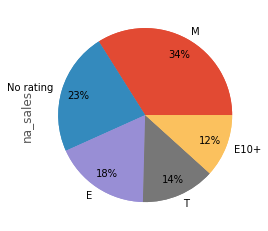

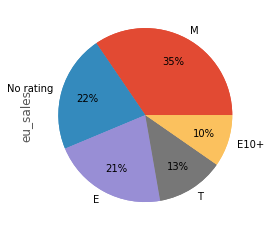

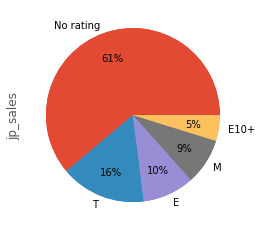

In [48]:
df_region=df[(df['year_of_release']>0)&(df['year_of_release']>=2014)].\
    groupby('rating').\
    agg({'na_sales': 'sum','eu_sales': 'sum','jp_sales': 'sum' })
df_region['na_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['na_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.8, labeldistance=2, startangle=0)
plt.show()
df_region['eu_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['eu_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()
df_region['jp_sales'].sort_values(ascending=False).head(5).plot(kind='pie')
plt.pie(df_region['jp_sales'].sort_values(ascending=False).head(5), autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.2)
plt.show()


- No rating  занимает заметное место, особенно в Японии;
- «M» («Mature») — «От 17 лет - наиболее популярны в США и ЕС.
- «E» («Everyone») — «Для всех» - занимает второе место везде.
- «E10+» («Everyone 10 and older») — «Для всех старше 10 лет» - наименее популярный жанр в виду наличие небольшого промежутка по возрасту от 10 до 12 лет. 
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Наиболее популярный жанр в Японии.



### Выводы

- наиболее популярные это Шутеры, которые значительно опережают по медиане и верхней квартиле другие жанры, также в этом жанре есть игра с максимальными продажами;
- во многих жанрах есть очень удачные игры продажи которых достигают млн. копий;
- наименее популярные и наименее успешные жанры — это стратегии, пазлы, приключения и симуляторы;
- хотя Экшены, Misk и Гонки в целом не очень удачные жанры, у этих жанров есть очень удачные игры;
- Платформы хотя и заняли третье место, но в целом среди этого жанра нет очень популярных игр.
- наибольшую долю рынка в США,  ЕС и категория Другие страны занимают PS4 и XOne;
- в ЕС популярна платформа РС в отличии от других регионов;
- предпочтения в Японии существенно отличаются от США и ЕС: наиболее популярны 3DS, PS4, PSV.
- в США и ЕС наиболее популярны: Шутеры, Акшины, Спорт и Ролевые игры.
- в США и Японии играют в Misk в отличии в ЕС;
- популярность игр в Японии отличается от США и ЕС: наиболее популярны ролевые игры, Экшены, Файтинги;
- категория другие страны наиболее похожа на США.
- «M» («Mature») — «От 17 лет - наиболее популярны в США и ЕС. Япония - третье место.
- «E» («Everyone») — «Для всех» - занимает второе место везде.
- «E10+» («Everyone 10 and older») — «Для всех старше 10 лет» - наименее популярный жанр в виду наличие небольшого промежутка по возрасту от 10 до 12 лет. 
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Наиболее популярный жанр в Японии.


## Статистический анализ


### Средние пользовательские рейтинги платформ Xbox One и PC


- H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- H1: Средние пользовательские рейтинги платформ Xbox One и PC различны.


In [49]:
results = st.ttest_ind(
    df[(df['platform']=='XOne')&(df['user_score']>0)&(df['year_of_release']>=2014)]['user_score'], 
    df[(df['platform']=='PC'  )&(df['user_score']>0)&(df['year_of_release']>=2014)]['user_score'], 
    nan_policy='omit',
    equal_var = False
)
print('p-значение: ', results.pvalue)

p-значение:  0.11601398086668827


st.ttest_ind предназначен для рассчета Т-критерия для средних значений двух независимых выборок.Это двусторонний тест для нулевой гипотезы о том, что 2 независимые выборки имеют одинаковые средние значения. Этот тест предполагает, что по умолчанию совокупности имеют идентичные дисперсии. Я использовал equal_var = False

Нулевая гипотеза не может быть отвергнута при альфа равного 0.05. Основываясь на полученных данным, можно утверждать, что средние пользовательские рейтинги платформ Xbox One и PC статистически не различаются.


- H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые;
- H1: Средние пользовательские рейтинги жанров Action  и Sports разные.

In [50]:
results = st.ttest_ind(
    df[(df['genre']=='Action')&(df['user_score']>0)&(df['year_of_release']>=2014)]['user_score'], 
    df[(df['genre']=='Sports')&(df['user_score']>0)&(df['year_of_release']>=2014)]['user_score'], 
    nan_policy='omit',
    equal_var = False
)
print('p-значение: ', results.pvalue)

p-значение:  1.1825550382644557e-14


Нулевая гипотеза может быть отвергнута стандартное значении альфа=0.05 позволяет сделать такой вывод. Таким образом гипотеза о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различны нашла подтверждение. 

# Общий вывод

- по сравнению с 1980 годом выпуск игр увеличился в больше чем на два порядка. Максимум выпуск игр достиг в 2008-2009 годах и потом начал уменьшаться.
- можно условно выделить следующие группы игр: "Неудачные" - до 3 лет жизни. "Средний вариант" - от 4 до 8 лет жизни.  "Ветераны" - от 10 лет -платформы завоевали свое место под солнцем и долго развивались;
- жизненный цикл для игровых платформ составляет 7.68 лет, поэтому выберем в качестве периода для прогноза соизмеримую увеличу в 3 года. Поэтому использовали данные с 2014 по 2016 года;
- лидируют по продажам PS4. Заметно отстают XOne и 3DS. Остальные платформы не заминают значительного положения по продажам;
-  в целом можно отметить весьма негативные тенденции по продажам игр для игровых платформ. Лучше всего выглядит PS4, но и в это случае на лицо явно выраженные негативные тенденции. Видимо, это связано с миграцией пользователей на онлайн-игры монетизация которых отлична от монетизации анализируемых игр;
- несмотря на лидерство платформы PS4 по суммарных продажах игр, в пересчете на одну игру медианна прибыль незначительно больше у таких игровых платформ как  XOne и  WiiU. В целом можно сказать, что медианные значения для первых 5 игровых платформ мало отличаются.  Также имеется значительно число выбросов для всех платформ. Размер третьего и верхнего квартиля на графиках позволяет сказать, что имеется значительно число игр, которые гораздо успешнее по продажам чем "типичная" игра платформы;
- существует прямая зависимость между оценкой критиков и продажами. Но связь эта умеренная. Связь между продажами и оценкой пользователей на основе расчета коэффициента Пирсона не выявлена. Результат для оценки пользователей является неожиданным, возможно, что имеется другие переменные, которые не были учтены в данном анализе. Для некоторых платформ корреляция между продажами и оценкой критиков имеет умеренное значение. Наибольшее значение среди наиболее популярных платформ WiiU=0.4. В тоже время оценка критиков имеет примерно одинаковое влияние на продажи для анализируемых платформ;
- наиболее популярные это Шутеры, которые значительно опережают по медиане и верхней квартиле другие жанры, также в этом жанре есть игра с максимальными продажами. Во многих жанрах есть очень удачные игры продажи которых достигают млн. копий.Наименее популярные и наименее успешные жанры — это стратегии, пазлы, приключения и симуляторы. Хотя Экшены, Misk и Гонки в целом не очень удачные жанры, у этих жанров есть очень удачные игры. Платформы хотя и заняли третье место, но в целом среди этого жанра нет очень популярных игр.
- Наибольшую долю рынка в Северной Америке,  ЕС и категория Другие страны занимают PS4 и XOne. В ЕС популярна платформа РС в отличии от других регионов. Предпочтения в Японии существенно отличаются от Северной Америки и ЕС: наиболее пополярны 3DS, PS4, PSV. Японцы отдают предпочтение отечественным платформам.
- В Северной Америке и ЕС наиболее популярны: Шутеры, Акшины, Спорт и Ролевые игры. В Северной Америке и Японии играют в Misk в отличии в ЕС.Популярность игр в Японии отличается от Северной Америки и ЕС: наиболее популярны ролевые игры, Экшены, Файтинги. Категория другие страны наиболее похожа на Северную Америку.
- No rating  занимает заметное место, особенно в Японии. «M» («Mature») — «От 17 лет - наиболее популярны в США и ЕС.
«E» («Everyone») — «Для всех» - занимает второе место везде. «E10+» («Everyone 10 and older») — «Для всех старше 10 лет»  наименее популярный жанр в виду наличие небольшого промежутка по возрасту от 10 до 12 лет. «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Наиболее популярный жанр в Японии.
- Основываясь на полученных данным, можно утверждать, что средние пользовательские рейтинги платформ Xbox One и PC статистически не различаются.
- Гипотеза о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») различны нашла подтверждение.

